In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix)
from catboost import CatBoostClassifier, Pool
import shap

In [2]:
df = pd.read_csv('dataframe_for_carpov_conf.csv')
#df.to_csv('dataframe_for_carpov_conf.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121164 entries, 0 to 121163
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                121164 non-null  int64  
 1   user_id                   121164 non-null  int64  
 2   month_since_first_order   121164 non-null  int64  
 3   is_verified_user          121164 non-null  int64  
 4   month_since_last_order    121164 non-null  int64  
 5   total_orders_count        121164 non-null  int64  
 6   avg_month_stickiness      121164 non-null  float64
 7   total_active_month        121164 non-null  int64  
 8   share_of_returned_orders  121164 non-null  float64
 9   web_orders_share          121164 non-null  float64
 10  target                    121164 non-null  int64  
 11  avg_app_open_monthly      121164 non-null  int64  
 12  max_purchase_value        121164 non-null  float64
 13  min_purchase_value        121164 non-null  f

In [5]:
df

,Unnamed: 0,user_id,month_since_first_order,is_verified_user,month_since_last_order,total_orders_count,avg_month_stickiness,total_active_month,share_of_returned_orders,web_orders_share,target,avg_app_open_monthly,max_purchase_value,min_purchase_value
0,0,0,17,0,0,0,0.0,0,0.0,0.0,1,19,0.000000,0.000000
1,1,1,15,1,0,28,0.0,0,0.0,0.0,0,8,0.000000,0.000000
2,2,2,1,1,0,0,0.0,0,0.0,0.0,0,2,0.000000,0.000000
3,3,3,12,1,0,0,0.0,0,0.0,0.0,0,5,0.000000,0.000000
4,4,4,2,1,0,23,0.0,0,0.0,0.0,1,8,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121159,121159,121159,0,1,0,0,0.0,0,0.0,0.0,1,37,0.000000,0.000000
121160,121160,121160,9,1,0,0,0.0,0,0.0,0.0,1,9,0.000000,0.000000
121161,121161,121161,1,1,0,0,0.0,0,0.0,0.0,1,6,0.000000,0.000000
121162,121162,121162,2,0,2,0,0.0,1,0.0,0.0,0,17,2.246108,0.074143


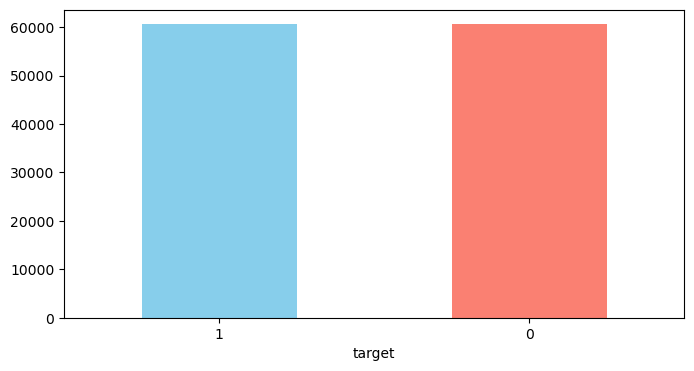

In [6]:
# проверка баланса классов целевой метрики, для наших аналитических задач лучше работать со сбалансированными датасетами или несильным искажением, до соотношения 1:5 +-

class_counts = df['target'].value_counts()
plt.figure(figsize=(8, 4))
class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.xticks(rotation=0)
plt.show()

In [7]:
# выделяем датафреймы для трейна, теста и валидации 
df_train_test = df.sample(frac=0.8, random_state=42)
df_validation = df.drop(df_train_test.index)

In [8]:
# убираем колонки 

X = df_train_test.drop(['target','user_id'], axis=1)
y = df_train_test['target']

X_val = df_validation.drop(['target','user_id'], axis=1)
y_val = df_validation['target']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42, stratify=y)

In [10]:
model = CatBoostClassifier(
    iterations=1000,          
    learning_rate=0.05,
    l2_leaf_reg = 0.03,      
    depth=8,                 
    random_state=42,
    eval_metric='Accuracy',
    verbose=200)

In [11]:
model.fit(
    X_train, y_train, 
    # cat_features=cat_features, # в нашем датафрейма категориальных переменных нет, если в вашем они будут - нужно будет передать их наименование сюда 
    eval_set=(X_test, y_test), 
    use_best_model=True,
    plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6926132	test: 0.6946547	best: 0.6946547 (0)	total: 65.8ms	remaining: 1m 5s
200:	learn: 0.7544104	test: 0.7165904	best: 0.7175447 (117)	total: 1.12s	remaining: 4.47s
400:	learn: 0.7954710	test: 0.7145915	best: 0.7175447 (117)	total: 2.15s	remaining: 3.21s
600:	learn: 0.8260085	test: 0.7130569	best: 0.7175447 (117)	total: 3.18s	remaining: 2.11s
800:	learn: 0.8474672	test: 0.7107873	best: 0.7175447 (117)	total: 4.2s	remaining: 1.04s
999:	learn: 0.8632518	test: 0.7088271	best: 0.7175447 (117)	total: 5.21s	remaining: 0us

bestTest = 0.7175446515
bestIteration = 117

Shrink model to first 118 iterations.


In [ ]:
# предсказание классов и вероятностей на тесте
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# метрики на основании предсказанных классов на тестовой выборке
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)
conf_mat = confusion_matrix(y_test, y_pred)

print(f"Accuracy:       {acc:.4f}")
print(f"Precision:      {prec:.4f}")
print(f"Recall:         {rec:.4f}")
print(f"F1-score:       {f1:.4f}")
print(f"ROC-AUC:        {auc_roc:.4f}")
print("Confusion Matrix:")
print(conf_mat)

Accuracy:       0.7175
Precision:      0.7015
Recall:         0.7563
F1-score:       0.7279
ROC-AUC:        0.7921
Confusion Matrix:
[[26344 12464]
 [ 9439 29298]]


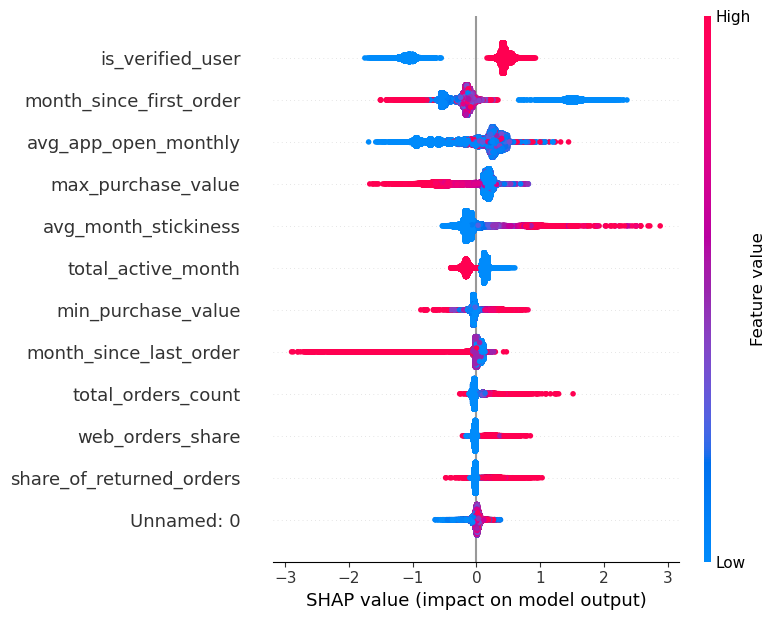

In [13]:
# визуализация вклада фичей в предсказание модели на тесте

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="dot")

In [14]:
# предсказание классов и вероятностей на валидационной выборке
y_val_pred = model.predict(X_val)
y_val_pred_proba = model.predict_proba(X_val)[:, 1]

# метрики на валидационной выборке
acc = accuracy_score(y_val, y_val_pred)
prec = precision_score(y_val, y_val_pred)
rec = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
auc_roc = roc_auc_score(y_val, y_val_pred_proba)
conf_mat = confusion_matrix(y_val, y_val_pred)

print(f"Accuracy:       {acc:.4f}")
print(f"Precision:      {prec:.4f}")
print(f"Recall:         {rec:.4f}")
print(f"F1-score:       {f1:.4f}")
print(f"ROC-AUC:        {auc_roc:.4f}")
print("Confusion Matrix:")
print(conf_mat)

Accuracy:       0.7129
Precision:      0.7000
Recall:         0.7488
F1-score:       0.7236
ROC-AUC:        0.7876
Confusion Matrix:
[[8170 3902]
 [3055 9106]]


In [15]:
# применяем модель на весь датасет для изучения зависимости скора с другими переменными

X_full = df.drop(['target', 'user_id'], axis=1)
df_scored = df.copy()
df_scored['score'] = model.predict_proba(X_full)[:, 1]

In [ ]:
# создаем "категории скоров" с шагом в 0.2

bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']
df_scored['score_group'] = pd.cut(df_scored['score'], bins=bins, labels=labels, include_lowest=True)

/var/folders/rh/cygl7mg53270fspqx92rv85m0000gn/T/ipykernel_62165/300976485.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_scored.groupby(['score_group', 'target']).size().unstack(fill_value=0)


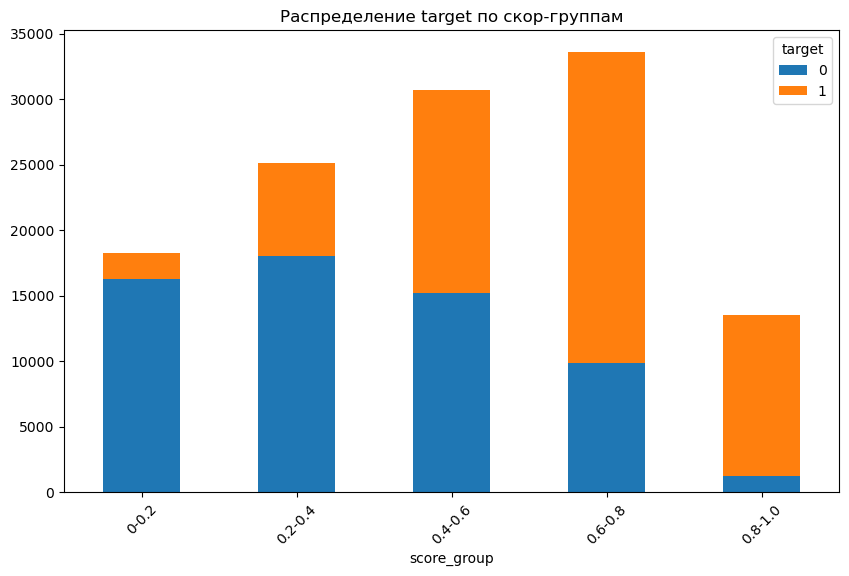

In [17]:
# Визуализируем

grouped = df_scored.groupby(['score_group', 'target']).size().unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Распределение target по скор-группам')
plt.xticks(rotation=45)
plt.show()

/var/folders/rh/cygl7mg53270fspqx92rv85m0000gn/T/ipykernel_62165/3468073962.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_metric = df_scored.groupby('score_group')[columns_for_calc].mean()


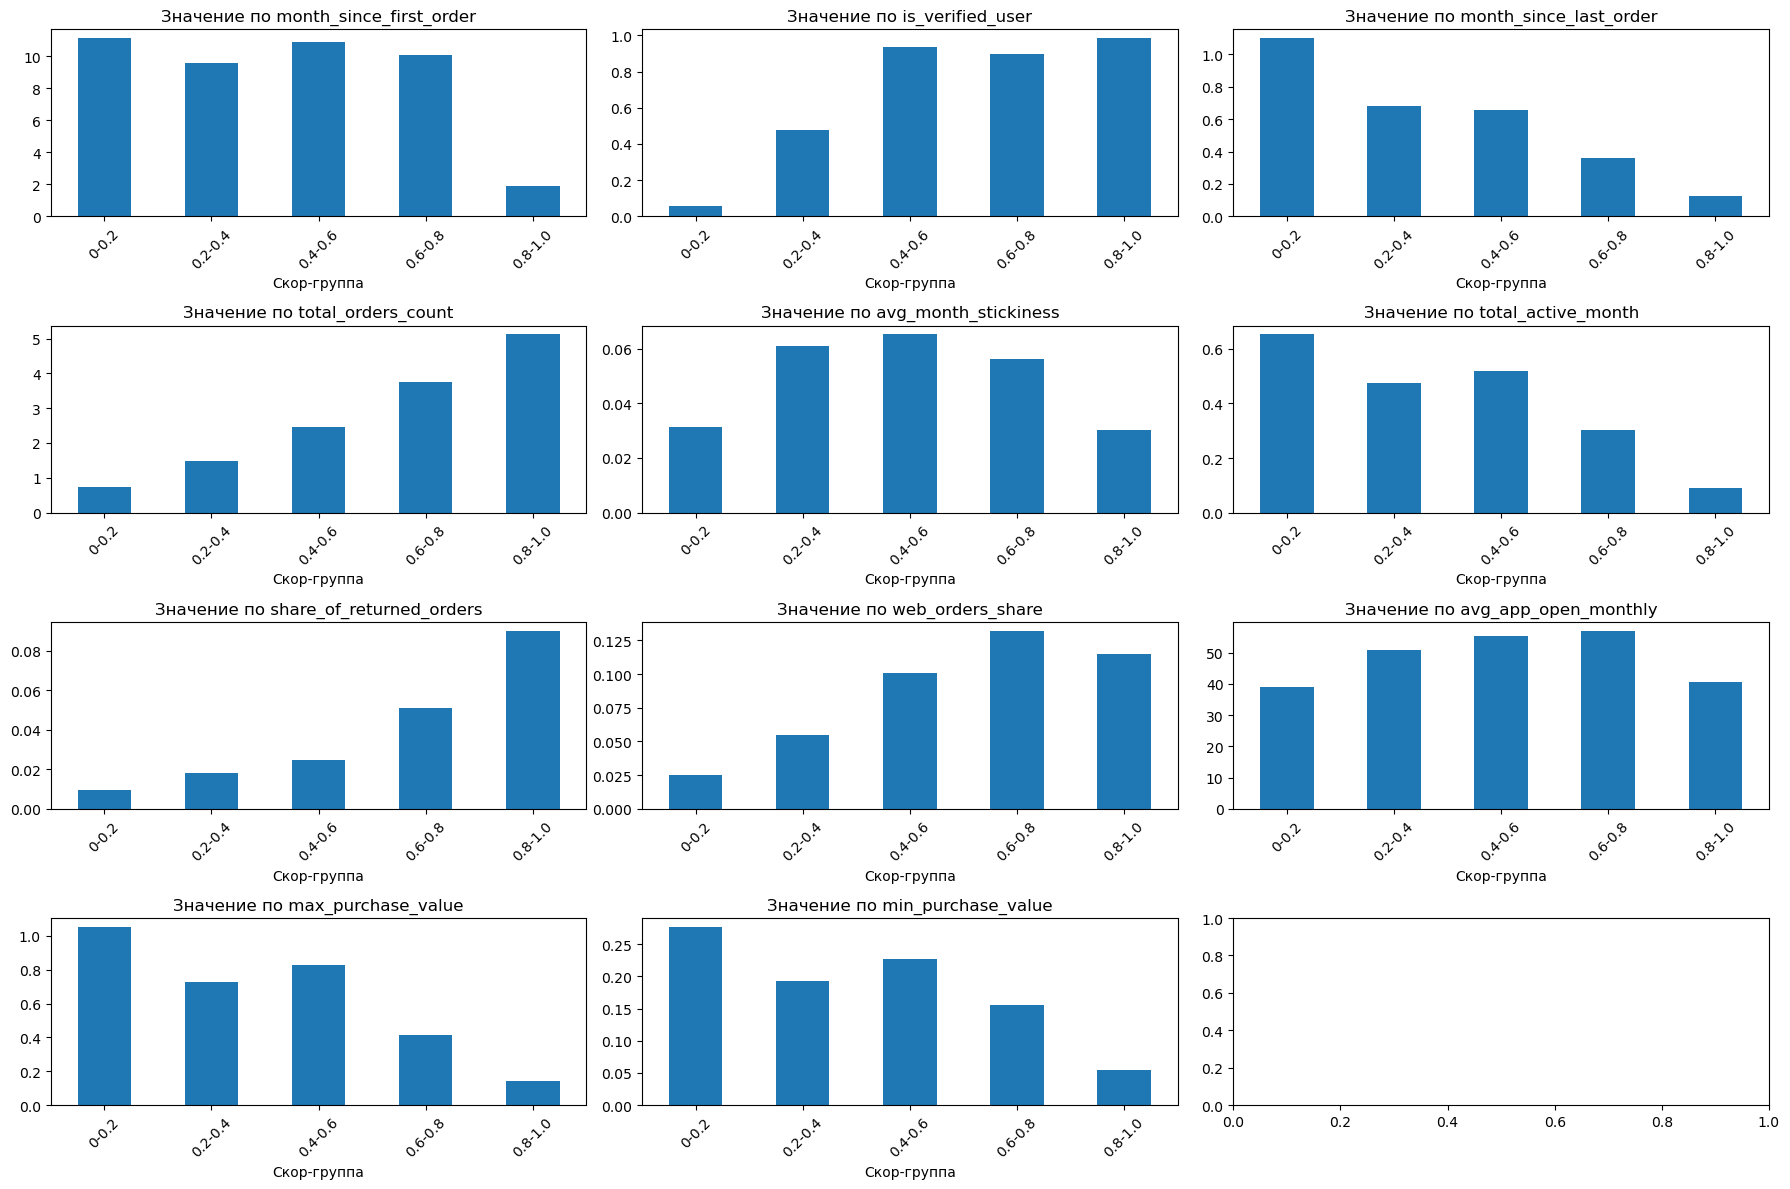

In [18]:
# Формируем визуализации для построения гипотез о зависимостях и клиентских портретах 

columns_for_calc = [
    'month_since_first_order', 'is_verified_user', 'month_since_last_order',
    'total_orders_count', 'avg_month_stickiness', 'total_active_month',
    'share_of_returned_orders', 'web_orders_share',
    'avg_app_open_monthly', 'max_purchase_value', 'min_purchase_value']

grouped_metric = df_scored.groupby('score_group')[columns_for_calc].mean()

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(columns_for_calc):
    grouped_metric[col].plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Значение по {col}')
    axes[i].set_xlabel('Скор-группа')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Термины:
Целевое действие - конверсия в наш целевой продукт или любое иное действие, котого мы хотим добиться от пользователя

Пример наблюдения:
- Мы обнаружили то, что у клиентов с большим скором относительно-высокая доля заказов через web канал. 
- Клиенты с высоким скором имеют сравнительно низкий средний lifetime.

Гипотезы:
1. Web канал предоставляет UX/UI , в большей мере отвечающих предпочтениям клиентов, склонным к целевому действию, а значит появление баннеров с call to action на конверсию в web версии поможет вырастить CR на Х. 
2. Новые пользователи по какой-то причине лучше конвертируются в целевое действие, а значит таргетированные коммуникации с новыми пользователями могут помочь оптимизировать бюджет без существенных изменений общего CR в целевое действие.

Действия:
1. Инициируем разработку баннера на web, проведем A/B тест на CR и оценим Uplift. 
2. Инициируем тестирование коммуникаций по ранжированному списку на бизнес правилах и оценим эффективность рассылки по сравнению с имеющимися алгоритмами выбора пользователей для рассылок.